In [135]:
from analysis.load_dataset import build_tg_data
import numpy as np
import torch
import pandas as pd
import torch_geometric as tg
import torch.nn.functional as F
from sklearn import metrics
from torch_geometric.nn import TransformerConv
from torch_geometric.utils import to_networkx, from_networkx


import networkx as nx
import matplotlib.pyplot as plt


In [136]:
def evaluate(y_truth,y_pred):
    auc = metrics.roc_auc_score(y_truth, y_pred, multi_class='ovo',labels=[0,1],average='macro')
    ap = metrics.average_precision_score(y_truth, y_pred, average='macro', pos_label=1, sample_weight=None)
    return ap,auc
def process_data(data,max_time_steps=32):
    data.edge_time = data.edge_time-data.edge_time.min() #process edge time
    data.edge_time = data.edge_time/data.edge_time.max()
    data.edge_time = (data.edge_time*max_time_steps).long()
    data.edge_time = data.edge_time.view(-1,1).float()
    
    
    edge = torch.cat([data.edge_index,data.edge_time.view(1,-1)],dim=0) #process node time
    degree = pd.DataFrame(edge.T.numpy()).groupby(0).min().values
    ids = pd.DataFrame(data.edge_index.T.numpy()).groupby(0).count().index.values 
    key = {}
    for i in range(data.x.shape[0]):
        key[i]=0
    for i in range(len(ids)):
        key[ids[i]]=degree[i][1]
    node_time = np.array(list(key.values()))
    data.node_time=torch.tensor(node_time)
    
    # trans to undirected graph
    data.edge_index = torch.cat((data.edge_index,data.edge_index[[1,0],:]),dim=1)
    data.edge_time = torch.cat((data.edge_time,data.edge_time),dim=0)

    return data

In [137]:
datapath = './dataset/DGraphFin/raw/dgraphfin.npz'
origin_data = np.load(datapath)
data = build_tg_data(is_undirected=False,datapath=datapath)
data = process_data(data)

device = torch.device('cpu')

In [138]:
data

Data(x=[3700550, 17], y=[3700550], edge_index=[2, 8601998], train_mask=[857899], val_mask=[183862], test_mask=[183840], edge_time=[8601998, 1], node_time=[3700550])

In [139]:
labels = data.y
# 获取每个标签对应的节点索引
label_indices = {}
unique_labels = labels.unique()

for label in unique_labels:
    label_indices[label.item()] = torch.nonzero(labels == label).view(-1)

# 打印每个标签对应的节点索引
for label, indices in label_indices.items():
    print(f"Label {label}: Node indices {indices}, shape {indices.shape}")

Label 0: Node indices tensor([      7,      13,      21,  ..., 3700381, 3700533, 3700541]), shape torch.Size([1210092])
Label 1: Node indices tensor([   1343,    1605,    1744,  ..., 3566027, 3566155, 3686679]), shape torch.Size([15509])
Label 2: Node indices tensor([      0,       2,       4,  ..., 3700547, 3700548, 3700549]), shape torch.Size([1620851])
Label 3: Node indices tensor([      1,       3,       5,  ..., 3699958, 3700226, 3700265]), shape torch.Size([854098])


In [140]:
normal, fraud, back1, back2 = label_indices[0], label_indices[1], label_indices[2], label_indices[3]

normal.shape, fraud.shape, back1.shape, back2.shape

(torch.Size([1210092]),
 torch.Size([15509]),
 torch.Size([1620851]),
 torch.Size([854098]))

In [141]:
labels, labels.shape

(tensor([2, 3, 2,  ..., 2, 2, 2]), torch.Size([3700550]))

In [142]:
g = to_networkx(data, to_undirected=True)
g

In [143]:
list(g.nodes())[:5]

[0, 1, 2, 3, 4]

In [144]:
normal_l = list(normal.numpy().tolist())
fraud_l = list(fraud.numpy().tolist())
back1_l = list(back1.numpy().tolist())
back2_l = list(back2.numpy().tolist())
normal_l[:10]


[7, 13, 21, 25, 30, 34, 37, 38, 39, 48]

#### 局部子图结构分析

In [26]:
ego_g = nx.ego_graph(g, 0, radius=3)
nx.constraint(ego_g)

{0: 1.0,
 146154: 0.25,
 2706580: 1.0,
 2476341: 0.9225,
 1542038: 1.0,
 707511: 0.5,
 1397336: 1.0,
 2639322: 0.30000000000000004,
 2461501: 0.9225,
 2850622: 1.0}

In [30]:
from numba import jit
from tqdm import tqdm

@jit
def ego_ana(g, ego_nodes, radius=3):
    ego_feats = []
    
    for node in tqdm(ego_nodes):
        ego_size = []
        ego_avg_deg = []
        ego_clu = []
        ego_con = []
        
        ego_subgraph = nx.ego_graph(g, node, radius)
        ego_size.append(len(ego_subgraph))
        ego_avg_deg.append(sum(list(dict(ego_subgraph.degree()).values()))/len(ego_subgraph))
        ego_clu.append(sum(list(nx.clustering(ego_subgraph).values()))/len(ego_subgraph))
        ego_con.append(sum(list(nx.constraint(ego_subgraph).values()))/len(ego_subgraph))

        ego_feats.append(ego_size)
        ego_feats.append(ego_avg_deg)
        ego_feats.append(ego_clu)
        ego_feats.append(ego_con)
    
    ego_feats = np.array(ego_feats)
    ego_feats = ego_feats/ego_feats.max(axis=0)

    return torch.tensor(ego_feats)


/tmp/ipykernel_3556326/4153053691.py:4: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @jit


In [31]:
normal_ego_feats = ego_ana(g, normal_l, radius=3)
normal_ego_feats, normal_ego_feats.shape

/tmp/ipykernel_3556326/4153053691.py:4: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "ego_ana" failed type inference due to: Untyped global name 'tqdm': Cannot determine Numba type of <class 'type'>

File "../../../tmp/ipykernel_3556326/4153053691.py", line 8:
<source missing, REPL/exec in use?>

  @jit
/users/Min/miniconda/lib/python3.11/site-packages/numba/core/object_mode_passes.py:151: NumbaWarning: Function "ego_ana" was compiled in object mode without forceobj=True.

File "../../../tmp/ipykernel_3556326/4153053691.py", line 4:
<source missing, REPL/exec in use?>

  warnings.warn(errors.NumbaWarning(warn_msg,
/users/Min/miniconda/lib/python3.11/site-packages/numba/core/object_mode_passes.py:161: NumbaDeprecationWarning: 
Fall-back from the nopython compilation path to the object mode compilation path has been detected. This is deprecated behaviour that will be removed in Numba 0.59.0.

For more information visit https://numba.

KeyboardInterrupt: 

In [ ]:
fraud_ego_feats = ego_ana(g, fraud_l, radius=3)
fraud_ego_feats, fraud_ego_feats.shape

In [173]:


def ego_plot(g, ego_nodes, radius):

    # 设置子图的行和列
    num_rows = 3
    num_cols = 3

    # 创建一个新的图形
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(10, 8))

    for i, node in enumerate(ego_nodes):
        # 计算子图在图中的位置
        row = i // num_cols
        col = i % num_cols

        ego_subgraph = nx.ego_graph(g, node, radius)

        # 创建一个节点标签的字典，设置橙色、绿色和红色的节点
        node_colors = ['g' if n in normal_l else 'r' if n in fraud_l else 'blue' if n in back1_l else 'orange' for n in ego_subgraph.nodes()]

        # 使用布局算法绘制ego子图
        pos = nx.spring_layout(ego_subgraph)
        
        # 绘制ego子图到相应的子图位置
        nx.draw(ego_subgraph, pos, with_labels=True, node_size=150, ax=axes[row, col], node_color=node_colors, font_size=6)
        
        # 设置标题
        axes[row, col].set_title(f'Ego Subgraph for Node {node}')

    # 调整子图之间的间距
    plt.tight_layout()

    # 显示图
    plt.show()


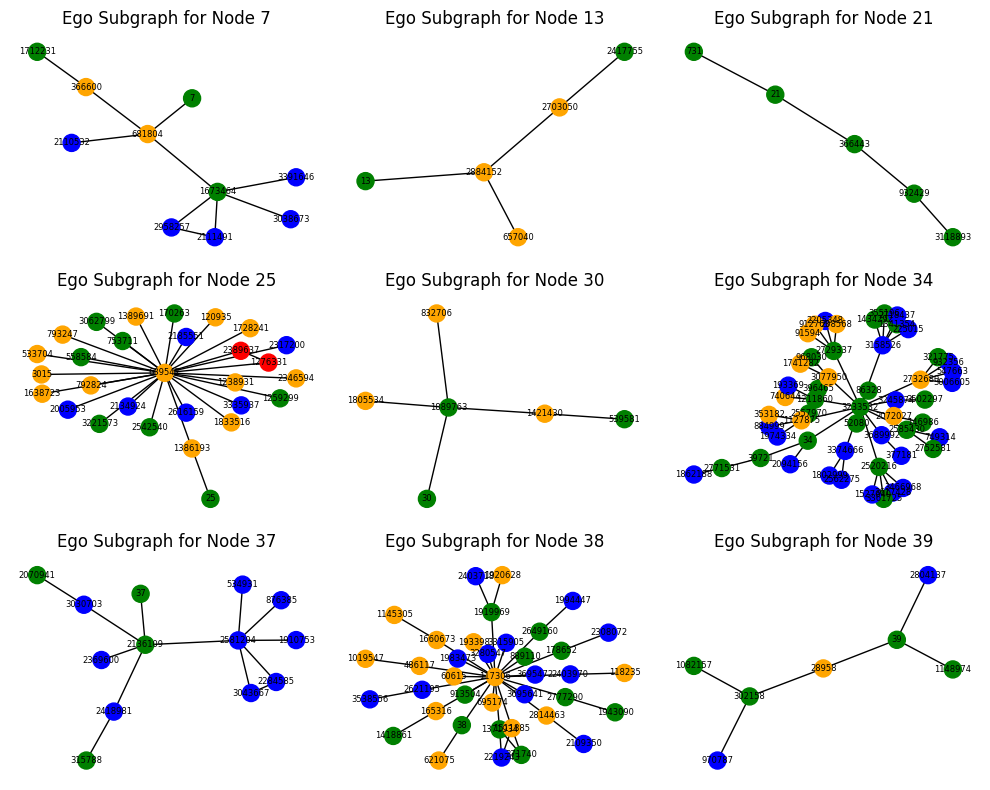

In [44]:
ego_plot(g, normal_l[:9], radius=3)

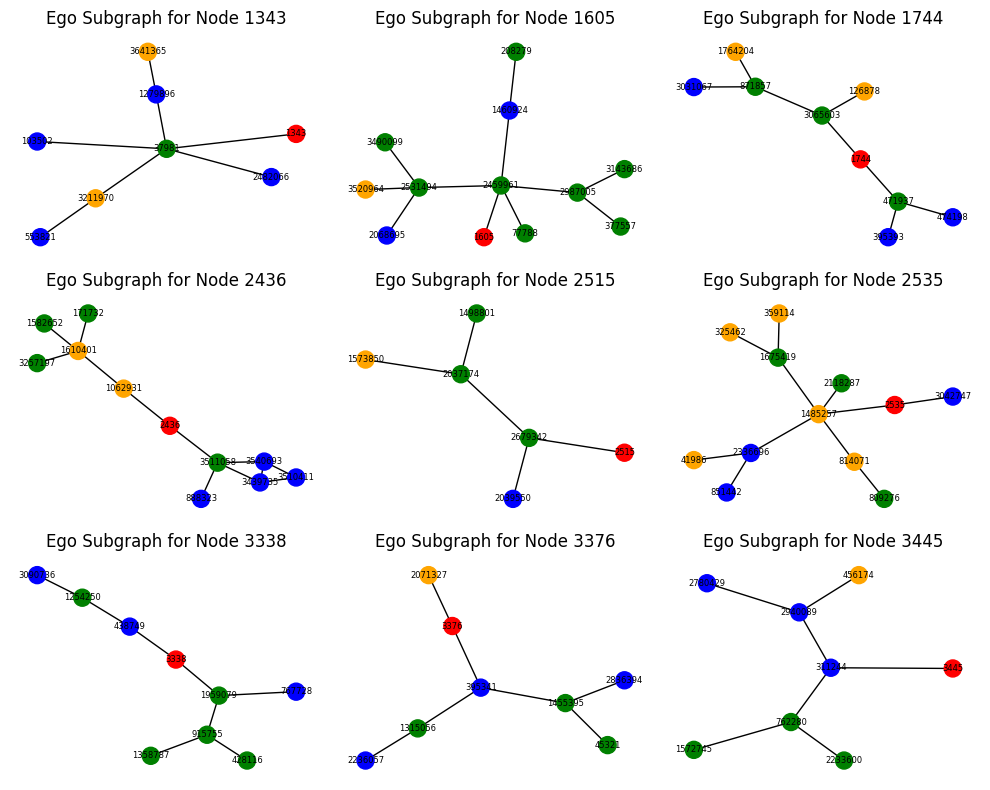

In [45]:
ego_plot(g, fraud_l[:9], radius=3)

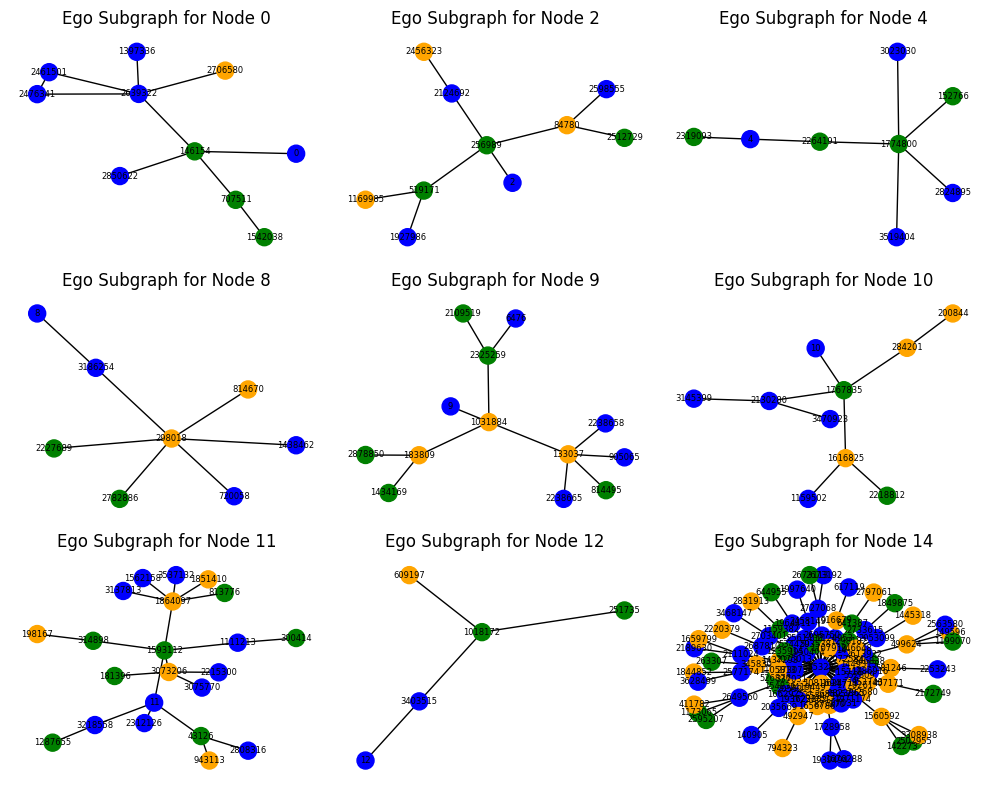

In [46]:
ego_plot(g, back1_l[:9], radius=3)

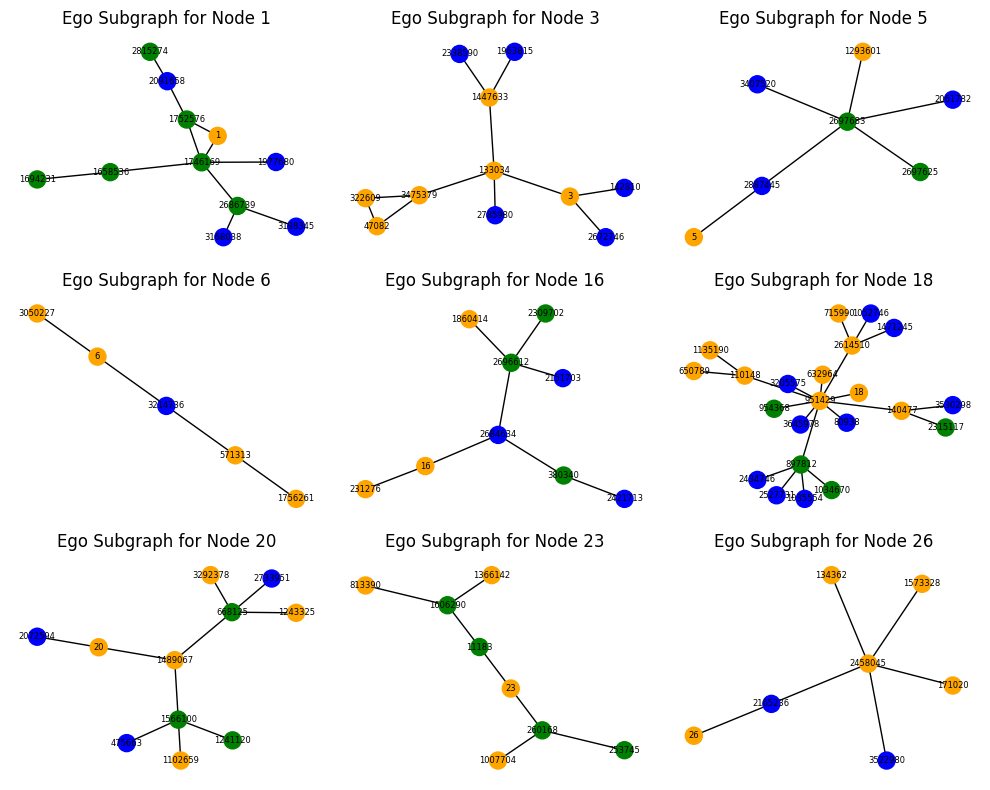

In [47]:
ego_plot(g, back2_l[:9], radius=3)

#### 节点属性分析

In [ ]:
data.x.shape

In [ ]:
def feats_plot(data, node_idx):
    # 定义子图的行和列数
    num_rows = 4  # 4行
    num_cols = 5  # 5列

    # 创建一个新的图形
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 12))

    # 遍历每列特征并绘制其分布
    for i in range(17):
        row = i // num_cols
        col = i % num_cols
        
        feature_values = data.x[node_idx, i].numpy()
        
        # 绘制特征列的直方图
        axes[row, col].hist(feature_values, bins=50, alpha=0.5, color='b', edgecolor='black')
        axes[row, col].set_title(f'Feature {i} Distribution')
        axes[row, col].set_xlabel('Feature Value')
        axes[row, col].set_ylabel('Frequency')

    # 调整子图之间的间距
    plt.tight_layout()

    # 显示图
    plt.show()

In [ ]:
feats_plot(data, normal)

In [ ]:
feats_plot(data, fraud)

In [ ]:
feats_plot(data, back1)

In [ ]:
feats_plot(data, back2)

In [ ]:
num_samples = data.x.shape[0]
# 将数据集分成多个块
block_size = 100  # 每个块的大小
num_blocks = num_samples // block_size

similarities = np.zeros((num_samples, num_samples))  # 存储相似性矩阵

for i in range(num_blocks):
    for j in range(i, num_blocks):
        start_i = i * block_size
        end_i = (i + 1) * block_size
        start_j = j * block_size
        end_j = (j + 1) * block_size
        
        # 获取两个块的数据
        block1 = data[start_i:end_i]
        block2 = data[start_j:end_j]
        
        # 计算块之间的余弦相似性
        block_similarity = cosine_similarity(block1, block2)
        
        # 更新相似性矩阵
        similarities[start_i:end_i, start_j:end_j] = block_similarity
        similarities[start_j:end_j, start_i:end_i] = block_similarity.T

In [ ]:
# 计算余弦相似性
def cosine_similarity(matrix):
    dot_product = np.dot(matrix, matrix.T)
    norms = np.linalg.norm(matrix, axis=1)
    norms_matrix = np.outer(norms, norms)
    similarity_matrix = dot_product / norms_matrix
    return similarity_matrix

# 计算余弦相似性矩阵
cosine_sim_matrix = cosine_similarity(data.x)

# 绘制热力图
plt.imshow(cosine_sim_matrix, cmap='coolwarm', interpolation='nearest')
plt.colorbar()
plt.title("Cosine Similarity Heatmap")
plt.show()

#### 时序信息分析

In [11]:
edge_time = data.edge_time
edge_index = data.edge_index
edge_time.shape, edge_index.shape

(torch.Size([8601998, 1]), torch.Size([2, 8601998]))

In [12]:
torch.unique(edge_time)

tensor([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13.,
        14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25., 26., 27.,
        28., 29., 30., 31., 32.])

In [145]:
node_time = data.node_time
node_time, node_time.shape

(tensor([0., 0., 0.,  ..., 0., 0., 0.], dtype=torch.float64),
 torch.Size([3700550]))

In [146]:
edge_index.t()[:5,:], edge_time[:5,:]

(tensor([[ 476699, 2915516],
         [ 347800, 1271242],
         [ 154317, 2104635],
         [ 497847, 3281634],
         [1541244,  372144]]),
 tensor([[ 9.],
         [10.],
         [ 9.],
         [18.],
         [ 0.]]))

findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not foun

时间 0.0: 242214 条边
时间 1.0: 280984 条边
时间 2.0: 196108 条边
时间 3.0: 215138 条边
时间 4.0: 212950 条边
时间 5.0: 216398 条边
时间 6.0: 269650 条边
时间 7.0: 276160 条边
时间 8.0: 309548 条边
时间 9.0: 291868 条边
时间 10.0: 209910 条边
时间 11.0: 211276 条边
时间 12.0: 214680 条边
时间 13.0: 238756 条边
时间 14.0: 351070 条边
时间 15.0: 519886 条边
时间 16.0: 427042 条边
时间 17.0: 445118 条边
时间 18.0: 352414 条边
时间 19.0: 309088 条边
时间 20.0: 247032 条边
时间 21.0: 237580 条边
时间 22.0: 269124 条边
时间 23.0: 253900 条边
时间 24.0: 241354 条边
时间 25.0: 220266 条边
时间 26.0: 192254 条边
时间 27.0: 190654 条边
时间 28.0: 237776 条边
时间 29.0: 242892 条边
时间 30.0: 243490 条边
时间 31.0: 226204 条边
时间 32.0: 9214 条边


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


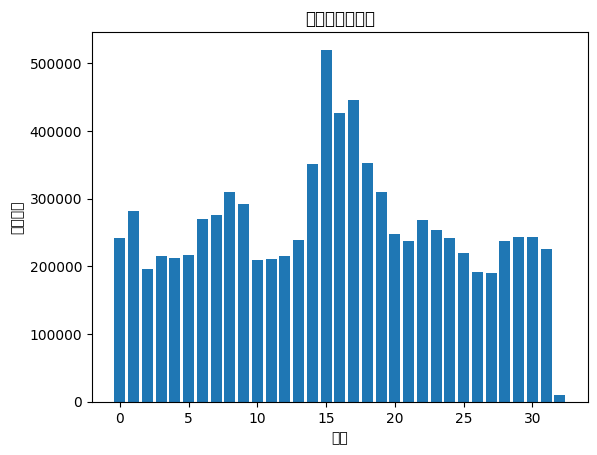

In [35]:
plt.rcParams['font.sans-serif']=['SimHei'] #用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False #用来正常显示负号

# 将 PyTorch 张量转换为 NumPy 数组
time_array = edge_time.numpy()
edge_array = edge_index.numpy()

# 获取时间张量的最小值和最大值
min_time = np.min(time_array)
max_time = np.max(time_array)

# 创建时间范围，例如 [0, 1, 2, ..., 32]，可以根据需要修改步长
time_range = np.arange(min_time, max_time + 1)

# 初始化一个字典来存储每个时间点对应的边的数量
edge_counts = {time: 0 for time in time_range}

# 统计每个时间点对应的边的数量
for i in range(len(time_array)):
    time = time_array[i][0]
    edge_counts[time] += 1


# 打印每个时间点对应的边的数量
for time, count in edge_counts.items():
    print(f"时间 {time}: {count} 条边")

# 获取时间和边的数量
times = list(edge_counts.keys())
edge_counts_values = list(edge_counts.values())

# 创建一个简单的直方图
plt.bar(times, edge_counts_values)

# 设置图的标题和坐标轴标签
plt.title("时间与边的分布")
plt.xlabel("时间")
plt.ylabel("边的数量")

# 显示图
plt.show()

In [147]:
node_time = (node_time - torch.min(node_time)) / (torch.max(node_time) - torch.min(node_time))
node_time[:5]

tensor([0.0000, 0.0000, 0.0000, 0.2500, 0.0000], dtype=torch.float64)

In [148]:
node_time.shape

torch.Size([3700550])

In [149]:
node_feats = data.x
node_feats, node_feats.shape

(tensor([[ 0.,  5., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.],
         [ 0.,  5., -1.,  ..., -1., -1., -1.],
         ...,
         [-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.]]),
 torch.Size([3700550, 17]))

时间 0.0: 1615094 条边
时间 1.0: 107563 条边
时间 2.0: 74780 条边
时间 3.0: 80882 条边
时间 4.0: 80995 条边
时间 5.0: 81608 条边
时间 6.0: 100026 条边
时间 7.0: 101728 条边
时间 8.0: 108730 条边
时间 9.0: 97210 条边
时间 10.0: 68183 条边
时间 11.0: 67470 条边
时间 12.0: 67701 条边
时间 13.0: 71219 条边
时间 14.0: 75484 条边
时间 15.0: 101519 条边
时间 16.0: 80154 条边
时间 17.0: 84531 条边
时间 18.0: 67446 条边
时间 19.0: 59693 条边
时间 20.0: 47202 条边
时间 21.0: 43165 条边
时间 22.0: 45715 条边
时间 23.0: 43119 条边
时间 24.0: 41600 条边
时间 25.0: 37463 条边
时间 26.0: 35411 条边
时间 27.0: 36534 条边
时间 28.0: 46257 条边
时间 29.0: 45585 条边
时间 30.0: 44684 条边
时间 31.0: 40196 条边
时间 32.0: 1603 条边


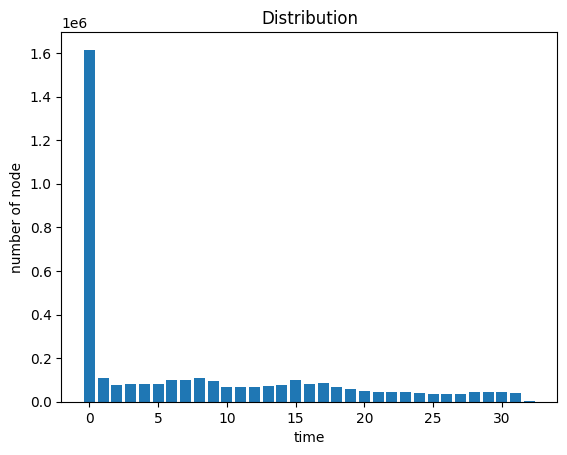

In [30]:
# 将 PyTorch 张量转换为 NumPy 数组
time_array = data.node_time.numpy()
node_array = np.array(range(data.x.shape[0]))

# 获取时间张量的最小值和最大值
min_time = np.min(time_array)
max_time = np.max(time_array)

# 创建时间范围，例如 [0, 1, 2, ..., 32]，可以根据需要修改步长
time_range = np.arange(min_time, max_time + 1)

# 初始化一个字典来存储每个时间点对应的边的数量
node_counts = {time: 0 for time in time_range}

# 统计每个时间点对应的边的数量
for i in range(len(time_array)):
    time = time_array[i]
    node_counts[time] += 1


# 打印每个时间点对应的边的数量
for time, count in node_counts.items():
    print(f"时间 {time}: {count} 条边")

# 获取时间和边的数量
times = list(node_counts.keys())
node_counts_values = list(node_counts.values())

# 创建一个简单的直方图
plt.bar(times, node_counts_values)

# 设置图的标题和坐标轴标签
plt.title("Distribution")
plt.xlabel("time")
plt.ylabel("number of node")

# 显示图
plt.show()

时间 0.0: 299533 条边
时间 1.0: 64841 条边
时间 2.0: 46259 条边
时间 3.0: 47352 条边
时间 4.0: 44031 条边
时间 5.0: 44655 条边
时间 6.0: 56891 条边
时间 7.0: 57259 条边
时间 8.0: 60438 条边
时间 9.0: 46579 条边
时间 10.0: 30455 条边
时间 11.0: 27318 条边
时间 12.0: 26794 条边
时间 13.0: 34082 条边
时间 14.0: 38198 条边
时间 15.0: 44509 条边
时间 16.0: 31734 条边
时间 17.0: 30487 条边
时间 18.0: 22211 条边
时间 19.0: 18174 条边
时间 20.0: 14049 条边
时间 21.0: 12756 条边
时间 22.0: 14287 条边
时间 23.0: 13193 条边
时间 24.0: 11752 条边
时间 25.0: 10274 条边
时间 26.0: 9116 条边
时间 27.0: 8809 条边
时间 28.0: 11203 条边
时间 29.0: 11866 条边
时间 30.0: 11114 条边
时间 31.0: 9593 条边
时间 32.0: 280 条边


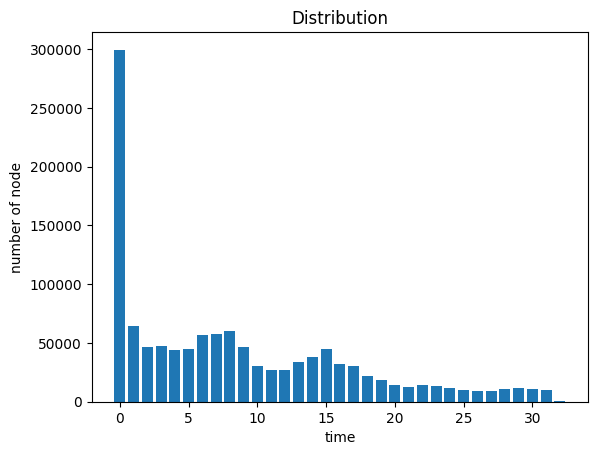

In [28]:
# 将 PyTorch 张量转换为 NumPy 数组
time_array = data.node_time[normal_l].numpy()
node_array = np.array(normal_l)

# 获取时间张量的最小值和最大值
min_time = np.min(time_array)
max_time = np.max(time_array)

# 创建时间范围，例如 [0, 1, 2, ..., 32]，可以根据需要修改步长
time_range = np.arange(min_time, max_time + 1)

# 初始化一个字典来存储每个时间点对应的边的数量
node_counts = {time: 0 for time in time_range}

# 统计每个时间点对应的边的数量
for i in range(len(time_array)):
    time = time_array[i]
    node_counts[time] += 1


# 打印每个时间点对应的边的数量
for time, count in node_counts.items():
    print(f"时间 {time}: {count} 条边")

# 获取时间和边的数量
times = list(node_counts.keys())
node_counts_values = list(node_counts.values())

# 创建一个简单的直方图
plt.bar(times, node_counts_values)

# 设置图的标题和坐标轴标签
plt.title("Distribution")
plt.xlabel("time")
plt.ylabel("number of node")

# 显示图
plt.show()

时间 0.0: 8975 条边
时间 1.0: 555 条边
时间 2.0: 311 条边
时间 3.0: 392 条边
时间 4.0: 461 条边
时间 5.0: 449 条边
时间 6.0: 509 条边
时间 7.0: 564 条边
时间 8.0: 663 条边
时间 9.0: 491 条边
时间 10.0: 222 条边
时间 11.0: 202 条边
时间 12.0: 200 条边
时间 13.0: 119 条边
时间 14.0: 136 条边
时间 15.0: 135 条边
时间 16.0: 100 条边
时间 17.0: 112 条边
时间 18.0: 91 条边
时间 19.0: 86 条边
时间 20.0: 69 条边
时间 21.0: 73 条边
时间 22.0: 59 条边
时间 23.0: 76 条边
时间 24.0: 82 条边
时间 25.0: 69 条边
时间 26.0: 73 条边
时间 27.0: 85 条边
时间 28.0: 62 条边
时间 29.0: 29 条边
时间 30.0: 33 条边
时间 31.0: 26 条边


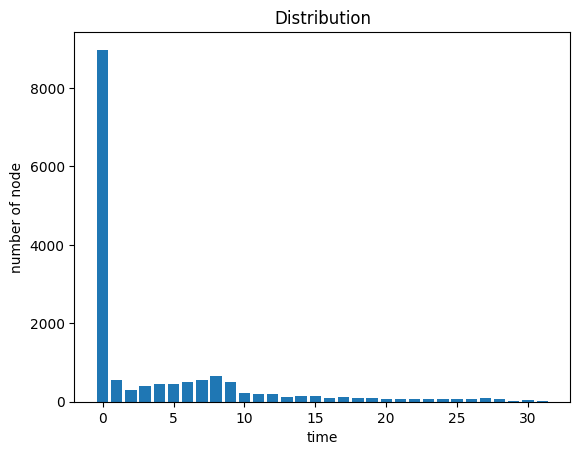

In [29]:
# 将 PyTorch 张量转换为 NumPy 数组
time_array = data.node_time[fraud_l].numpy()
node_array = np.array(fraud_l)

# 获取时间张量的最小值和最大值
min_time = np.min(time_array)
max_time = np.max(time_array)

# 创建时间范围，例如 [0, 1, 2, ..., 32]，可以根据需要修改步长
time_range = np.arange(min_time, max_time + 1)

# 初始化一个字典来存储每个时间点对应的边的数量
node_counts = {time: 0 for time in time_range}

# 统计每个时间点对应的边的数量
for i in range(len(time_array)):
    time = time_array[i]
    node_counts[time] += 1


# 打印每个时间点对应的边的数量
for time, count in node_counts.items():
    print(f"时间 {time}: {count} 条边")

# 获取时间和边的数量
times = list(node_counts.keys())
node_counts_values = list(node_counts.values())

# 创建一个简单的直方图
plt.bar(times, node_counts_values)

# 设置图的标题和坐标轴标签
plt.title("Distribution")
plt.xlabel("time")
plt.ylabel("number of node")

# 显示图
plt.show()

时间 0.0: 892362 条边
时间 1.0: 24952 条边
时间 2.0: 16259 条边
时间 3.0: 18896 条边
时间 4.0: 20248 条边
时间 5.0: 20352 条边
时间 6.0: 22642 条边
时间 7.0: 23449 条边
时间 8.0: 27119 条边
时间 9.0: 28454 条边
时间 10.0: 23201 条边
时间 11.0: 23412 条边
时间 12.0: 24391 条边
时间 13.0: 21018 条边
时间 14.0: 21147 条边
时间 15.0: 30941 条边
时间 16.0: 23324 条边
时间 17.0: 29267 条边
时间 18.0: 28519 条边
时间 19.0: 29768 条边
时间 20.0: 24775 条边
时间 21.0: 22864 条边
时间 22.0: 23814 条边
时间 23.0: 22765 条边
时间 24.0: 22512 条边
时间 25.0: 19181 条边
时间 26.0: 18500 条边
时间 27.0: 19776 条边
时间 28.0: 25199 条边
时间 29.0: 24230 条边
时间 30.0: 24238 条边
时间 31.0: 22228 条边
时间 32.0: 1048 条边


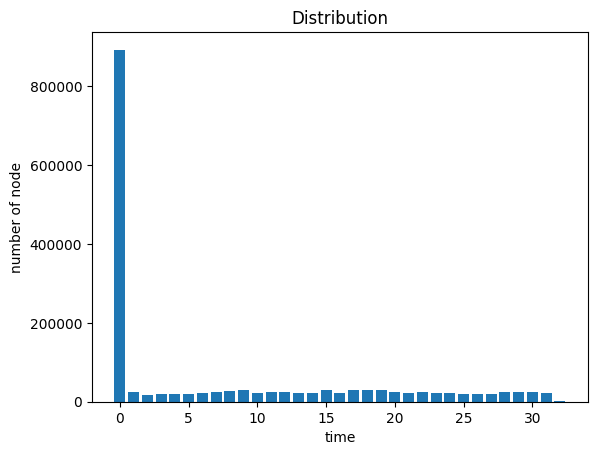

In [31]:
# 将 PyTorch 张量转换为 NumPy 数组
time_array = data.node_time[back1_l].numpy()
node_array = np.array(back1_l)

# 获取时间张量的最小值和最大值
min_time = np.min(time_array)
max_time = np.max(time_array)

# 创建时间范围，例如 [0, 1, 2, ..., 32]，可以根据需要修改步长
time_range = np.arange(min_time, max_time + 1)

# 初始化一个字典来存储每个时间点对应的边的数量
node_counts = {time: 0 for time in time_range}

# 统计每个时间点对应的边的数量
for i in range(len(time_array)):
    time = time_array[i]
    node_counts[time] += 1


# 打印每个时间点对应的边的数量
for time, count in node_counts.items():
    print(f"时间 {time}: {count} 条边")

# 获取时间和边的数量
times = list(node_counts.keys())
node_counts_values = list(node_counts.values())

# 创建一个简单的直方图
plt.bar(times, node_counts_values)

# 设置图的标题和坐标轴标签
plt.title("Distribution")
plt.xlabel("time")
plt.ylabel("number of node")

# 显示图
plt.show()

时间 0.0: 414224 条边
时间 1.0: 17215 条边
时间 2.0: 11951 条边
时间 3.0: 14242 条边
时间 4.0: 16255 条边
时间 5.0: 16152 条边
时间 6.0: 19984 条边
时间 7.0: 20456 条边
时间 8.0: 20510 条边
时间 9.0: 21686 条边
时间 10.0: 14305 条边
时间 11.0: 16538 条边
时间 12.0: 16316 条边
时间 13.0: 16000 条边
时间 14.0: 16003 条边
时间 15.0: 25934 条边
时间 16.0: 24996 条边
时间 17.0: 24665 条边
时间 18.0: 16625 条边
时间 19.0: 11665 条边
时间 20.0: 8309 条边
时间 21.0: 7472 条边
时间 22.0: 7555 条边
时间 23.0: 7085 条边
时间 24.0: 7254 条边
时间 25.0: 7939 条边
时间 26.0: 7722 条边
时间 27.0: 7864 条边
时间 28.0: 9793 条边
时间 29.0: 9460 条边
时间 30.0: 9299 条边
时间 31.0: 8349 条边
时间 32.0: 275 条边


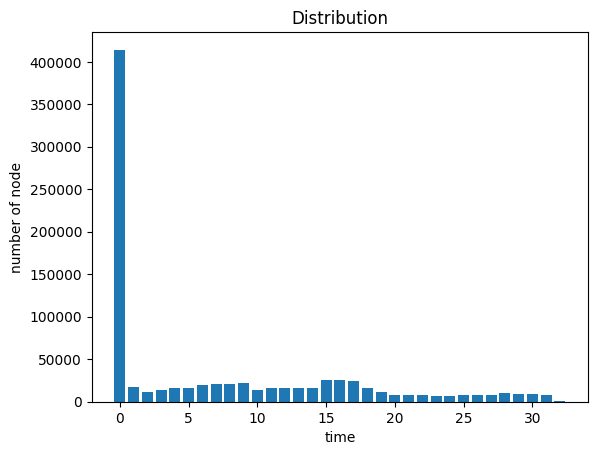

In [32]:
# 将 PyTorch 张量转换为 NumPy 数组
time_array = data.node_time[back2_l].numpy()
node_array = np.array(back2_l)

# 获取时间张量的最小值和最大值
min_time = np.min(time_array)
max_time = np.max(time_array)

# 创建时间范围，例如 [0, 1, 2, ..., 32]，可以根据需要修改步长
time_range = np.arange(min_time, max_time + 1)

# 初始化一个字典来存储每个时间点对应的边的数量
node_counts = {time: 0 for time in time_range}

# 统计每个时间点对应的边的数量
for i in range(len(time_array)):
    time = time_array[i]
    node_counts[time] += 1


# 打印每个时间点对应的边的数量
for time, count in node_counts.items():
    print(f"时间 {time}: {count} 条边")

# 获取时间和边的数量
times = list(node_counts.keys())
node_counts_values = list(node_counts.values())

# 创建一个简单的直方图
plt.bar(times, node_counts_values)

# 设置图的标题和坐标轴标签
plt.title("Distribution")
plt.xlabel("time")
plt.ylabel("number of node")

# 显示图
plt.show()

In [34]:
from typing import Callable, List, NamedTuple, Optional, Tuple, Union

import torch
from torch import Tensor

from torch_geometric.typing import SparseTensor

value = torch.arange(edge_index.size(1))
num_nodes = data.x.shape[0]

adj_t = SparseTensor(row=edge_index[0], col=edge_index[1],
                                      value=value,
                                      sparse_sizes=(num_nodes, num_nodes)).t()

In [36]:
from torch_geometric.nn.models import LabelPropagation

model = LabelPropagation(num_layers=3, alpha=0.9)
out = model(data.y, adj_t, mask=data.train_mask)

y_pred = out.argmax(dim=-1, keepdim=True)
y_pred

tensor([[0],
        [0],
        [0],
        ...,
        [0],
        [0],
        [0]])

In [38]:
val_ap, val_auc = evaluate(data.y[data.val_mask], y_pred[data.val_mask])
test_ap, test_auc = evaluate(data.y[data.test_mask], y_pred[data.test_mask])

print(val_ap, val_auc)
print(test_ap, test_auc)

0.012881052923298148 0.5026407691530032
0.012843199827813831 0.502287852728087


In [150]:
# 按列归一化
node_feats = node_feats / torch.norm(node_feats, dim=0)

node_feats = torch.concat((node_feats, node_time.unsqueeze(1).float()), dim=1)
node_feats, node_feats.shape

(tensor([[ 0.0000,  0.0007, -0.0004,  ..., -0.0006, -0.0006,  0.0000],
         [-0.0006, -0.0001, -0.0004,  ..., -0.0006, -0.0006,  0.0000],
         [ 0.0000,  0.0007, -0.0004,  ..., -0.0006, -0.0006,  0.0000],
         ...,
         [-0.0006, -0.0001, -0.0004,  ..., -0.0006, -0.0006,  0.0000],
         [-0.0006, -0.0001, -0.0004,  ..., -0.0006, -0.0006,  0.0000],
         [-0.0006, -0.0001, -0.0004,  ..., -0.0006, -0.0006,  0.0000]]),
 torch.Size([3700550, 18]))

In [151]:
node_time

tensor([0., 0., 0.,  ..., 0., 0., 0.], dtype=torch.float64)

#### GCN model

In [124]:
from typing import Union

from torch import Tensor
from torch_sparse import SparseTensor
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv

'''
此模型邻居矩阵采用sparse tensor的形式，可以大大减少计算量，
如果不使用sparse tensor形式传递，将adj_t替换成edge_index
'''
class GCN(torch.nn.Module):
    def __init__(self
                 , in_channels
                 , hidden_channels
                 , out_channels
                 , num_layers
                 , dropout
                 , batchnorm=True):
        super(GCN, self).__init__()

        self.convs = torch.nn.ModuleList()
        self.convs.append(GCNConv(in_channels, hidden_channels, cached=True))
        self.batchnorm = batchnorm
        if self.batchnorm:
            self.bns = torch.nn.ModuleList()
            self.bns.append(torch.nn.BatchNorm1d(hidden_channels))
        for _ in range(num_layers - 2):
            self.convs.append(
                GCNConv(hidden_channels, hidden_channels, cached=True))
            if self.batchnorm: 
                self.bns.append(torch.nn.BatchNorm1d(hidden_channels))
        self.convs.append(GCNConv(hidden_channels, out_channels, cached=True))

        self.dropout = dropout

    def reset_parameters(self):
        for conv in self.convs:
            conv.reset_parameters()
        if self.batchnorm:
            for bn in self.bns:
                bn.reset_parameters()

    def forward(self, x, edge_index: Union[Tensor, SparseTensor]):
        for i, conv in enumerate(self.convs[:-1]):
            x = conv(x, edge_index)
            if self.batchnorm: 
                x = self.bns[i](x)
            x = F.relu(x)
            x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.convs[-1](x, edge_index)
        return x.log_softmax(dim=-1)

In [125]:
from typing import Union

from torch import Tensor
from torch_sparse import SparseTensor
import torch
import torch.nn.functional as F
from torch_geometric.nn import SAGEConv

class SAGE(torch.nn.Module):
    def __init__(self
                 , in_channels
                 , hidden_channels
                 , out_channels
                 , num_layers
                 , dropout
                 , batchnorm=True):
        super(SAGE, self).__init__()

        self.convs = torch.nn.ModuleList()
        self.convs.append(SAGEConv(in_channels, hidden_channels))
        self.bns = torch.nn.ModuleList()
        self.batchnorm = batchnorm
        if self.batchnorm:
            self.bns.append(torch.nn.BatchNorm1d(hidden_channels))
        for _ in range(num_layers - 2):
            self.convs.append(SAGEConv(hidden_channels, hidden_channels))
            if self.batchnorm:
                self.bns.append(torch.nn.BatchNorm1d(hidden_channels))
        self.convs.append(SAGEConv(hidden_channels, out_channels))

        self.dropout = dropout

    def reset_parameters(self):
        for conv in self.convs:
            conv.reset_parameters()
        if self.batchnorm:
            for bn in self.bns:
                bn.reset_parameters()

    def forward(self, x, edge_index: Union[Tensor, SparseTensor]):
        for i, conv in enumerate(self.convs[:-1]):
            x = conv(x, edge_index)
            if self.batchnorm: 
                x = self.bns[i](x)
            x = F.relu(x)
            x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.convs[-1](x, edge_index)
        return x.log_softmax(dim=-1)
    

In [126]:
from typing import Union

from torch import Tensor
from torch_sparse import SparseTensor
import torch
import torch.nn.functional as F
from torch_geometric.nn import GATConv, GATv2Conv

class GAT(torch.nn.Module):
    def __init__(self
                 , in_channels
                 , hidden_channels
                 , out_channels
                 , num_layers
                 , dropout
                 , layer_heads = []
                 , batchnorm=True):
        super(GAT, self).__init__()

        self.convs = torch.nn.ModuleList()
        self.convs.append(GATConv(in_channels, hidden_channels, heads=layer_heads[0], concat=True))
        self.bns = torch.nn.ModuleList()
        self.batchnorm = batchnorm
        if self.batchnorm:
            self.bns.append(torch.nn.BatchNorm1d(hidden_channels*layer_heads[0]))
        for _ in range(num_layers - 2):
            self.convs.append(GATConv(hidden_channels*layer_heads[i-1], hidden_channels, heads=layer_heads[i], concat=True))
            if self.batchnorm:
                self.bns.append(torch.nn.BatchNorm1d(hidden_channels*layer_heads[i-1]))
        self.convs.append(GATConv(hidden_channels*layer_heads[num_layers-2]
                          , out_channels
                          , heads=layer_heads[num_layers-1]
                          , concat=False))

        self.dropout = dropout

    def reset_parameters(self):
        for conv in self.convs:
            conv.reset_parameters()
        if self.batchnorm:
            for bn in self.bns:
                bn.reset_parameters()

    def forward(self, x, edge_index: Union[Tensor, SparseTensor]):
        for i, conv in enumerate(self.convs[:-1]):
            x = conv(x, edge_index)
            if self.batchnorm: 
                x = self.bns[i](x)
            x = F.relu(x)
            x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.convs[-1](x, edge_index)
        return x.log_softmax(dim=-1)
    
    
    
    
class GATv2(torch.nn.Module):
    def __init__(self
                 , in_channels
                 , hidden_channels
                 , out_channels
                 , num_layers
                 , dropout
                 , layer_heads = []
                 , batchnorm=True):
        super(GATv2, self).__init__()

        self.convs = torch.nn.ModuleList()
        self.convs.append(GATv2Conv(in_channels, hidden_channels, heads=layer_heads[0], concat=True))
        self.bns = torch.nn.ModuleList()
        self.batchnorm = batchnorm
        if self.batchnorm:
            self.bns.append(torch.nn.BatchNorm1d(hidden_channels*layer_heads[0]))
        for _ in range(num_layers - 2):
            self.convs.append(GATv2Conv(hidden_channels*layer_heads[i-1], hidden_channels, heads=layer_heads[i], concat=True))
            if self.batchnorm:
                self.bns.append(torch.nn.BatchNorm1d(hidden_channels*layer_heads[i-1]))
        self.convs.append(GATv2Conv(hidden_channels*layer_heads[num_layers-2]
                          , out_channels
                          , heads=layer_heads[num_layers-1]
                          , concat=False))

        self.dropout = dropout

    def reset_parameters(self):
        for conv in self.convs:
            conv.reset_parameters()
        if self.batchnorm:
            for bn in self.bns:
                bn.reset_parameters()

    def forward(self, x, edge_index: Union[Tensor, SparseTensor]):
        for i, conv in enumerate(self.convs[:-1]):
            x = conv(x, edge_index)
            if self.batchnorm: 
                x = self.bns[i](x)
            x = F.relu(x)
            x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.convs[-1](x, edge_index)
        return x.log_softmax(dim=-1)

In [161]:
# dataset name: DGraphFin

from utils import DGraphFin
from utils.utils import prepare_folder
from utils.evaluator import Evaluator
from utils.tricks import Missvalues
from utils.tricks import Background
from utils.tricks import Structure
# from models import MLP, MLPLinear, GCN, SAGE, GAT, GATv2,RGCN
from logger import Logger

import argparse

import torch
import torch.nn.functional as F
import torch.nn as nn

import torch_geometric as tg
import torch_geometric.transforms as T

from torch_sparse import SparseTensor
from torch_geometric.utils import to_undirected
import pandas as pd
import numpy as np
import time
eval_metric = 'auc'

mlp_parameters = {'lr':0.01
              , 'num_layers':2
              , 'hidden_channels':64
              , 'dropout':0.0
              , 'batchnorm': False
              , 'l2':5e-7
             }

gcn_parameters = {'lr':0.01
              , 'num_layers':2
              , 'hidden_channels':64
              , 'dropout':0.0
              , 'batchnorm': False
              , 'l2':5e-7
             }

sage_parameters = {'lr':0.01
              , 'num_layers':2
              , 'hidden_channels':64
              , 'dropout':0
              , 'batchnorm': False
              , 'l2':5e-7
             }


def train(model, data, train_idx, optimizer, weight=None, no_conv=False,is_rgcn=False):
    # data.y is labels of shape (N, ) 
    model.train()

    optimizer.zero_grad()
    if no_conv:
        out = model(data.x[train_idx])
    else:
        if(is_rgcn):
            out = model(data.x, data.edge_index, data.edge_type)[train_idx]
        else:
            out = model(data.x, data.edge_index)[train_idx]
    # print('*'*50)
    # print(out.type, data.y.type(), train_idx.type(), weight.type())
    loss = F.nll_loss(out, data.y[train_idx],weight = weight)
    loss.backward()
    optimizer.step()

    return loss.item()


@torch.no_grad()
def test(model, data, split_idx, evaluator, no_conv=False,is_rgcn=True):
    # data.y is labels of shape (N, )
    model.eval()
    
    if no_conv:
        out = model(data.x)
    else:
        if(is_rgcn):
            out = model(data.x, data.edge_index, data.edge_type)
        else:
            out = model(data.x, data.edge_index)
        
    y_pred = out.exp()  # (N,num_classes)
    
    losses, eval_results = dict(), dict()
    for key in ['train', 'valid', 'test']:
        node_id = split_idx[key]
        losses[key] = F.nll_loss(out[node_id], data.y[node_id]).item()
        eval_results[key] = evaluator.eval(data.y[node_id], y_pred[node_id])
            
    return eval_results, losses, y_pred


In [128]:
import torch
import torch.nn.functional as F

class MLP(torch.nn.Module):
    def __init__(self
                 , in_channels
                 , hidden_channels
                 , out_channels
                 , num_layers
                 , dropout
                 , batchnorm=True):
        super(MLP, self).__init__()
        self.lins = torch.nn.ModuleList()
        self.lins.append(torch.nn.Linear(in_channels, hidden_channels))
        self.batchnorm = batchnorm
        if self.batchnorm:
            self.bns = torch.nn.ModuleList()
            self.bns.append(torch.nn.BatchNorm1d(hidden_channels))
        for _ in range(num_layers - 2):
            self.lins.append(torch.nn.Linear(hidden_channels, hidden_channels))
            if self.batchnorm:
                self.bns.append(torch.nn.BatchNorm1d(hidden_channels))
        self.lins.append(torch.nn.Linear(hidden_channels, out_channels))

        self.dropout = dropout

    def reset_parameters(self):
        for lin in self.lins:
            lin.reset_parameters()
        if self.batchnorm:
            for bn in self.bns:
                bn.reset_parameters()

    def forward(self, x):    
        for i, lin in enumerate(self.lins[:-1]):
            x = lin(x)
            if self.batchnorm:
                x = self.bns[i](x)
            x = F.relu(x)
            x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.lins[-1](x)
        return F.log_softmax(x, dim=-1)
    
    

class MLPLinear(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super(MLPLinear, self).__init__()
        self.lin = torch.nn.Linear(in_channels, out_channels)

    def reset_parameters(self):
        self.lin.reset_parameters()

    def forward(self, x):
        return F.log_softmax(self.lin(x), dim=-1)


In [152]:
device = f'cuda:{0}' if torch.cuda.is_available() else 'cpu'
device = torch.device(device)
# device = torch.device('cpu')
dataset = DGraphFin(root='./dataset/', name='DGraphFin', transform=T.ToSparseTensor())

data = dataset[0]
data.edge_index = data.adj_t
data.adj_t = torch.cat([data.edge_index.coo()[0].view(1,-1),data.edge_index.coo()[1].view(1,-1)],dim=0)
data.edge_index = data.adj_t
structure = Structure('original')
data = structure.process(data)
data.adj_t = data.edge_index
data.adj_t = tg.utils.to_undirected(data.adj_t)
data.edge_index = data.adj_t
if dataset in ['DGraphFin']:
    x = data.x
    x = (x-x.mean(0))/x.std(0)
    data.x = x
if data.y.dim()==2:
    data.y = data.y.squeeze(1)        

nlabels = 2

model = 'gcn'

no_conv = False
if model in ['mlp']: no_conv = True 

missvalues = Missvalues('null')
data = missvalues.process(data)

data.edge_index = data.adj_t
BN = Background('null')
data = BN.process(data,0.1)
print(data)
split_idx = {'train':data.train_mask, 'valid':data.valid_mask, 'test':data.test_mask}

fold = 0
if split_idx['train'].dim()>1 and split_idx['train'].shape[1] >1:
    kfolds = True
    print('There are {} folds of splits'.format(split_idx['train'].shape[1]))
    split_idx['train'] = split_idx['train'][:, fold]
    split_idx['valid'] = split_idx['valid'][:, fold]
    split_idx['test'] = split_idx['test'][:, fold]
else:
    kfolds = False

split_idx = {'train':data.train_mask, 'valid':data.valid_mask, 'test':data.test_mask}

data = data.to(device)
train_idx = split_idx['train'].to(device)
    
result_dir = prepare_folder('DGrapgFin', model)
print('result_dir:', result_dir)



is_rgcn=False
if model == 'mlp':
    para_dict = mlp_parameters
    model_para = mlp_parameters.copy()
    model_para.pop('lr')
    model_para.pop('l2')
    model = MLP(in_channels = data.x.size(-1), out_channels = nlabels, **model_para).to(device)
if model == 'gcn':   
    para_dict = gcn_parameters
    model_para = gcn_parameters.copy()
    model_para.pop('lr')
    model_para.pop('l2')        
    model = GCN(in_channels = data.x.size(-1), out_channels = nlabels, **model_para).to(device)
if model == 'sage':        
    para_dict = sage_parameters
    model_para = sage_parameters.copy()
    model_para.pop('lr')
    model_para.pop('l2')        
    model = SAGE(in_channels = data.x.size(-1), out_channels = nlabels, **model_para).to(device)
# if model == 'rgcn':   
#     para_dict = gcn_parameters
#     model = RGCN(data.x.size(-1),16,2,4).to(device)
#     is_rgcn=True
print(f'Model {model} initialized')



Data(x=[3700550, 17], edge_attr=[4300999], y=[3700550], train_mask=[857899], valid_mask=[183862], test_mask=[183840], adj_t=[2, 7994520], edge_index=[2, 7994520])
result_dir: ./model_results/DGrapgFin/gcn
Model GCN(
  (convs): ModuleList(
    (0): GCNConv(17, 64)
    (1): GCNConv(64, 2)
  )
) initialized


In [64]:
evaluator = Evaluator(eval_metric)
logger = Logger(2)
weight = torch.tensor([1,50]).to(device).float()

for run in range(2):
    import gc
    gc.collect()
    print(sum(p.numel() for p in model.parameters()))

    model.reset_parameters()
    optimizer = torch.optim.Adam(model.parameters(), lr=para_dict['lr'], weight_decay=para_dict['l2'])
    best_valid = 0
    min_valid_loss = 1e8
    best_out = None
    
    time_ls = []
    starttime = time.time()
    for epoch in range(1, 400):
        starttime = time.time()
        loss = train(model, data, train_idx, optimizer, weight,no_conv,is_rgcn)
        
        endtime = time.time()
        time_ls.append(endtime-starttime)
        eval_results, losses, out = test(model, data, split_idx, evaluator,no_conv,is_rgcn)
        train_auc, valid_auc, test_auc = eval_results['train']['auc'], eval_results['valid']['auc'], eval_results['test']['auc']
        train_ap, valid_ap, test_ap = eval_results['train']['ap'], eval_results['valid']['ap'], eval_results['test']['ap']
                                                                                                
        train_loss, valid_loss, test_loss = losses['train'], losses['valid'], losses['test']
        #print(eval_results['train'])
#                 if valid_eval > best_valid:
#                     best_valid = valid_result
#                     best_out = out.cpu().exp()
        
        if valid_loss < min_valid_loss:
            min_valid_loss = valid_loss
            best_out = out.cpu()
        
        
        if epoch % 10 == 0:
            print(f'Run: {run + 1:02d}, '
                        f'Epoch: {epoch:02d}, '
                        f'Loss: {loss:.4f}, '
                        f'Train AUC: {train_auc:.3f} '
                        f'Train AP: {train_ap:.3f} '
                        f'Valid AUC: {valid_auc:.3f} '
                        f'Valid AP: {valid_ap:.3f} '
                        f'Test AUC: { test_auc:.3f} '
                        f'Test AP: { test_ap:.3f} '
                        f'Train time(s): {np.mean(time_ls):.3f}')
            
            
            time_ls = []
        logger.add_result(run, [train_auc, valid_auc, test_auc])

    logger.print_statistics(run)

final_results = logger.print_statistics()
print('final_results:', final_results)
para_dict.update(final_results)
pd.DataFrame(para_dict, index=[model]).to_csv(result_dir+'/results.csv')

1282
Run: 01, Epoch: 10, Loss: 0.6409, Train AUC: 0.657 Train AP: 0.020 Valid AUC: 0.656 Valid AP: 0.020 Test AUC: 0.660 Test AP: 0.020 Train time(s): 14.967
Run: 01, Epoch: 20, Loss: 0.6299, Train AUC: 0.702 Train AP: 0.027 Valid AUC: 0.697 Valid AP: 0.026 Test AUC: 0.704 Test AP: 0.026 Train time(s): 15.446
Run: 01, Epoch: 30, Loss: 0.6166, Train AUC: 0.688 Train AP: 0.024 Valid AUC: 0.685 Valid AP: 0.024 Test AUC: 0.689 Test AP: 0.023 Train time(s): 17.015
Run: 01, Epoch: 40, Loss: 0.6070, Train AUC: 0.706 Train AP: 0.028 Valid AUC: 0.701 Valid AP: 0.027 Test AUC: 0.707 Test AP: 0.027 Train time(s): 17.154
Run: 01, Epoch: 50, Loss: 0.6014, Train AUC: 0.709 Train AP: 0.028 Valid AUC: 0.703 Valid AP: 0.028 Test AUC: 0.709 Test AP: 0.027 Train time(s): 15.008
Run: 01, Epoch: 60, Loss: 0.5968, Train AUC: 0.714 Train AP: 0.029 Valid AUC: 0.708 Valid AP: 0.028 Test AUC: 0.713 Test AP: 0.028 Train time(s): 14.513
Run: 01, Epoch: 70, Loss: 0.5933, Train AUC: 0.718 Train AP: 0.029 Valid AUC:

#### 编码时间信息到节点特征中， GCN model perfromance

In [153]:

data1 = data
data1.x = node_feats.to(torch.float32)

print(data1)
split_idx = {'train':data1.train_mask, 'valid':data1.valid_mask, 'test':data1.test_mask}

fold = 0
if split_idx['train'].dim()>1 and split_idx['train'].shape[1] >1:
    kfolds = True
    print('There are {} folds of splits'.format(split_idx['train'].shape[1]))
    split_idx['train'] = split_idx['train'][:, fold]
    split_idx['valid'] = split_idx['valid'][:, fold]
    split_idx['test'] = split_idx['test'][:, fold]
else:
    kfolds = False

split_idx = {'train':data1.train_mask, 'valid':data1.valid_mask, 'test':data1.test_mask}



data1 = data1.to(device)
train_idx = split_idx['train'].to(device)
    
result_dir = prepare_folder('DGrapgFin', model)
print('result_dir:', result_dir)

is_rgcn=False




Data(x=[3700550, 18], edge_attr=[4300999], y=[3700550], train_mask=[857899], valid_mask=[183862], test_mask=[183840], adj_t=[2, 7994520], edge_index=[2, 7994520])
result_dir: ./model_results/DGrapgFin/GCN(
  (convs): ModuleList(
    (0): GCNConv(17, 64)
    (1): GCNConv(64, 2)
  )
)


In [154]:
data.x, data.x.shape

(tensor([[ 0.0000,  0.0007, -0.0004,  ..., -0.0006, -0.0006,  0.0000],
         [-0.0006, -0.0001, -0.0004,  ..., -0.0006, -0.0006,  0.0000],
         [ 0.0000,  0.0007, -0.0004,  ..., -0.0006, -0.0006,  0.0000],
         ...,
         [-0.0006, -0.0001, -0.0004,  ..., -0.0006, -0.0006,  0.0000],
         [-0.0006, -0.0001, -0.0004,  ..., -0.0006, -0.0006,  0.0000],
         [-0.0006, -0.0001, -0.0004,  ..., -0.0006, -0.0006,  0.0000]]),
 torch.Size([3700550, 18]))

In [155]:
model = GCN(in_channels=data1.x.size(-1), hidden_channels=64, out_channels=2, num_layers=2, dropout=0.0, batchnorm=False)
print(f'Model {model} initialized')



Model GCN(
  (convs): ModuleList(
    (0): GCNConv(18, 64)
    (1): GCNConv(64, 2)
  )
) initialized


In [162]:
evaluator = Evaluator(eval_metric)
logger = Logger(2)
weight = torch.tensor([1,50]).to(device).float()

for run in range(2):
    import gc
    gc.collect()
    print(sum(p.numel() for p in model.parameters()))

    model.reset_parameters()
    optimizer = torch.optim.Adam(model.parameters(), lr=para_dict['lr'], weight_decay=para_dict['l2'])
    best_valid = 0
    min_valid_loss = 1e8
    best_out = None
    
    time_ls = []
    starttime = time.time()
    for epoch in range(1, 400):
        starttime = time.time()
        loss = train(model, data1, train_idx, optimizer, weight,no_conv,is_rgcn)
        
        endtime = time.time()
        time_ls.append(endtime-starttime)
        eval_results, losses, out = test(model, data1, split_idx, evaluator,no_conv,is_rgcn)
        train_auc, valid_auc, test_auc = eval_results['train']['auc'], eval_results['valid']['auc'], eval_results['test']['auc']
        train_ap, valid_ap, test_ap = eval_results['train']['ap'], eval_results['valid']['ap'], eval_results['test']['ap']
                                                                                                
        train_loss, valid_loss, test_loss = losses['train'], losses['valid'], losses['test']
        #print(eval_results['train'])
#                 if valid_eval > best_valid:
#                     best_valid = valid_result
#                     best_out = out.cpu().exp()
        
        if valid_loss < min_valid_loss:
            min_valid_loss = valid_loss
            best_out = out.cpu()
        
        
        if epoch % 10 == 0:
            print(f'Run: {run + 1:02d}, '
                        f'Epoch: {epoch:02d}, '
                        f'Loss: {loss:.4f}, '
                        f'Train AUC: {train_auc:.3f} '
                        f'Train AP: {train_ap:.3f} '
                        f'Valid AUC: {valid_auc:.3f} '
                        f'Valid AP: {valid_ap:.3f} '
                        f'Test AUC: { test_auc:.3f} '
                        f'Test AP: { test_ap:.3f} '
                        f'Train time(s): {np.mean(time_ls):.3f}')
            
            
            time_ls = []
        logger.add_result(run, [train_auc, valid_auc, test_auc])

    logger.print_statistics(run)

final_results = logger.print_statistics()
print('final_results:', final_results)
para_dict.update(final_results)
pd.DataFrame(para_dict, index=[model]).to_csv(result_dir+'/time_results.csv')

1346


Run: 01, Epoch: 10, Loss: 0.6586, Train AUC: 0.663 Train AP: 0.024 Valid AUC: 0.656 Valid AP: 0.024 Test AUC: 0.669 Test AP: 0.025 Train time(s): 15.866
Run: 01, Epoch: 20, Loss: 0.6526, Train AUC: 0.640 Train AP: 0.022 Valid AUC: 0.633 Valid AP: 0.022 Test AUC: 0.648 Test AP: 0.023 Train time(s): 16.279
Run: 01, Epoch: 30, Loss: 0.6489, Train AUC: 0.644 Train AP: 0.022 Valid AUC: 0.637 Valid AP: 0.022 Test AUC: 0.652 Test AP: 0.024 Train time(s): 16.438
Run: 01, Epoch: 40, Loss: 0.6461, Train AUC: 0.639 Train AP: 0.022 Valid AUC: 0.632 Valid AP: 0.022 Test AUC: 0.646 Test AP: 0.023 Train time(s): 16.174
Run: 01, Epoch: 50, Loss: 0.6443, Train AUC: 0.640 Train AP: 0.022 Valid AUC: 0.633 Valid AP: 0.022 Test AUC: 0.647 Test AP: 0.023 Train time(s): 16.464
Run: 01, Epoch: 60, Loss: 0.6424, Train AUC: 0.647 Train AP: 0.023 Valid AUC: 0.640 Valid AP: 0.023 Test AUC: 0.654 Test AP: 0.024 Train time(s): 17.108
Run: 01, Epoch: 70, Loss: 0.6406, Train AUC: 0.654 Train AP: 0.023 Valid AUC: 0.64

KeyboardInterrupt: 

#### GraphSage

In [157]:
device = f'cuda:{0}' if torch.cuda.is_available() else 'cpu'
device = torch.device(device)
# device = torch.device('cpu')
dataset = DGraphFin(root='./dataset/', name='DGraphFin', transform=T.ToSparseTensor())

data = dataset[0]
data.edge_index = data.adj_t
data.adj_t = torch.cat([data.edge_index.coo()[0].view(1,-1),data.edge_index.coo()[1].view(1,-1)],dim=0)
data.edge_index = data.adj_t
structure = Structure('original')
data = structure.process(data)
data.adj_t = data.edge_index
data.adj_t = tg.utils.to_undirected(data.adj_t)
data.edge_index = data.adj_t
if dataset in ['DGraphFin']:
    x = data.x
    x = (x-x.mean(0))/x.std(0)
    data.x = x
if data.y.dim()==2:
    data.y = data.y.squeeze(1)        

nlabels = 2

model = 'sage'

no_conv = False
if model in ['mlp']: no_conv = True 

missvalues = Missvalues('null')
data = missvalues.process(data)

data.edge_index = data.adj_t
BN = Background('null')
data = BN.process(data,0.1)
print(data)
split_idx = {'train':data.train_mask, 'valid':data.valid_mask, 'test':data.test_mask}

fold = 0
if split_idx['train'].dim()>1 and split_idx['train'].shape[1] >1:
    kfolds = True
    print('There are {} folds of splits'.format(split_idx['train'].shape[1]))
    split_idx['train'] = split_idx['train'][:, fold]
    split_idx['valid'] = split_idx['valid'][:, fold]
    split_idx['test'] = split_idx['test'][:, fold]
else:
    kfolds = False

split_idx = {'train':data.train_mask, 'valid':data.valid_mask, 'test':data.test_mask}

data = data.to(device)
train_idx = split_idx['train'].to(device)
    
result_dir = prepare_folder('DGrapgFin', model)
print('result_dir:', result_dir)



is_rgcn=False
if model == 'mlp':
    para_dict = mlp_parameters
    model_para = mlp_parameters.copy()
    model_para.pop('lr')
    model_para.pop('l2')
    model = MLP(in_channels = data.x.size(-1), out_channels = nlabels, **model_para).to(device)
if model == 'gcn':   
    para_dict = gcn_parameters
    model_para = gcn_parameters.copy()
    model_para.pop('lr')
    model_para.pop('l2')        
    model = GCN(in_channels = data.x.size(-1), out_channels = nlabels, **model_para).to(device)
if model == 'sage':        
    para_dict = sage_parameters
    model_para = sage_parameters.copy()
    model_para.pop('lr')
    model_para.pop('l2')        
    model = SAGE(in_channels = data.x.size(-1), out_channels = nlabels, **model_para).to(device)
# if model == 'rgcn':   
#     para_dict = gcn_parameters
#     model = RGCN(data.x.size(-1),16,2,4).to(device)
#     is_rgcn=True
print(f'Model {model} initialized')



'torch.FloatTensor'

In [ ]:
evaluator = Evaluator(eval_metric)
logger = Logger(2)
weight = torch.tensor([1,50]).to(device).float()

for run in range(2):
    import gc
    gc.collect()
    print(sum(p.numel() for p in model.parameters()))

    model.reset_parameters()
    optimizer = torch.optim.Adam(model.parameters(), lr=para_dict['lr'], weight_decay=para_dict['l2'])
    best_valid = 0
    min_valid_loss = 1e8
    best_out = None
    
    time_ls = []
    starttime = time.time()
    for epoch in range(1, 400):
        starttime = time.time()
        loss = train(model, data, train_idx, optimizer, weight,no_conv,is_rgcn)
        
        endtime = time.time()
        time_ls.append(endtime-starttime)
        eval_results, losses, out = test(model, data, split_idx, evaluator,no_conv,is_rgcn)
        train_auc, valid_auc, test_auc = eval_results['train']['auc'], eval_results['valid']['auc'], eval_results['test']['auc']
        train_ap, valid_ap, test_ap = eval_results['train']['ap'], eval_results['valid']['ap'], eval_results['test']['ap']
                                                                                                
        train_loss, valid_loss, test_loss = losses['train'], losses['valid'], losses['test']
        #print(eval_results['train'])
#                 if valid_eval > best_valid:
#                     best_valid = valid_result
#                     best_out = out.cpu().exp()
        
        if valid_loss < min_valid_loss:
            min_valid_loss = valid_loss
            best_out = out.cpu()
        
        
        if epoch % 10 == 0:
            print(f'Run: {run + 1:02d}, '
                        f'Epoch: {epoch:02d}, '
                        f'Loss: {loss:.4f}, '
                        f'Train AUC: {train_auc:.3f} '
                        f'Train AP: {train_ap:.3f} '
                        f'Valid AUC: {valid_auc:.3f} '
                        f'Valid AP: {valid_ap:.3f} '
                        f'Test AUC: { test_auc:.3f} '
                        f'Test AP: { test_ap:.3f} '
                        f'Train time(s): {np.mean(time_ls):.3f}')
            
            
            time_ls = []
        logger.add_result(run, [train_auc, valid_auc, test_auc])

    logger.print_statistics(run)

final_results = logger.print_statistics()
print('final_results:', final_results)
para_dict.update(final_results)
pd.DataFrame(para_dict, index=[model]).to_csv(result_dir+'/sage_results.csv')

#### GAT

In [ ]:
device = f'cuda:{0}' if torch.cuda.is_available() else 'cpu'
device = torch.device(device)
# device = torch.device('cpu')
dataset = DGraphFin(root='./dataset/', name='DGraphFin', transform=T.ToSparseTensor())

data = dataset[0]
data.edge_index = data.adj_t
data.adj_t = torch.cat([data.edge_index.coo()[0].view(1,-1),data.edge_index.coo()[1].view(1,-1)],dim=0)
data.edge_index = data.adj_t
structure = Structure('original')
data = structure.process(data)
data.adj_t = data.edge_index
data.adj_t = tg.utils.to_undirected(data.adj_t)
data.edge_index = data.adj_t
if dataset in ['DGraphFin']:
    x = data.x
    x = (x-x.mean(0))/x.std(0)
    data.x = x
if data.y.dim()==2:
    data.y = data.y.squeeze(1)        

nlabels = 2

model = 'gat'

no_conv = False
if model in ['mlp']: no_conv = True 

missvalues = Missvalues('null')
data = missvalues.process(data)

data.edge_index = data.adj_t
BN = Background('null')
data = BN.process(data,0.1)
print(data)
split_idx = {'train':data.train_mask, 'valid':data.valid_mask, 'test':data.test_mask}

fold = 0
if split_idx['train'].dim()>1 and split_idx['train'].shape[1] >1:
    kfolds = True
    print('There are {} folds of splits'.format(split_idx['train'].shape[1]))
    split_idx['train'] = split_idx['train'][:, fold]
    split_idx['valid'] = split_idx['valid'][:, fold]
    split_idx['test'] = split_idx['test'][:, fold]
else:
    kfolds = False

split_idx = {'train':data.train_mask, 'valid':data.valid_mask, 'test':data.test_mask}

data = data.to(device)
train_idx = split_idx['train'].to(device)
    
result_dir = prepare_folder('DGrapgFin', model)
print('result_dir:', result_dir)



is_rgcn=False
if model == 'mlp':
    para_dict = mlp_parameters
    model_para = mlp_parameters.copy()
    model_para.pop('lr')
    model_para.pop('l2')
    model = MLP(in_channels = data.x.size(-1), out_channels = nlabels, **model_para).to(device)
if model == 'gcn':   
    para_dict = gcn_parameters
    model_para = gcn_parameters.copy()
    model_para.pop('lr')
    model_para.pop('l2')        
    model = GCN(in_channels = data.x.size(-1), out_channels = nlabels, **model_para).to(device)
if model == 'sage':        
    para_dict = sage_parameters
    model_para = sage_parameters.copy()
    model_para.pop('lr')
    model_para.pop('l2')        
    model = SAGE(in_channels = data.x.size(-1), out_channels = nlabels, **model_para).to(device)
# if model == 'rgcn':   
#     para_dict = gcn_parameters
#     model = RGCN(data.x.size(-1),16,2,4).to(device)
#     is_rgcn=True
print(f'Model {model} initialized')



evaluator = Evaluator(eval_metric)
logger = Logger(2)
weight = torch.tensor([1,50]).to(device).float()

for run in range(2):
    import gc
    gc.collect()
    print(sum(p.numel() for p in model.parameters()))

    model.reset_parameters()
    optimizer = torch.optim.Adam(model.parameters(), lr=para_dict['lr'], weight_decay=para_dict['l2'])
    best_valid = 0
    min_valid_loss = 1e8
    best_out = None
    
    time_ls = []
    starttime = time.time()
    for epoch in range(1, 400):
        starttime = time.time()
        loss = train(model, data, train_idx, optimizer, weight,no_conv,is_rgcn)
        
        endtime = time.time()
        time_ls.append(endtime-starttime)
        eval_results, losses, out = test(model, data, split_idx, evaluator,no_conv,is_rgcn)
        train_auc, valid_auc, test_auc = eval_results['train']['auc'], eval_results['valid']['auc'], eval_results['test']['auc']
        train_ap, valid_ap, test_ap = eval_results['train']['ap'], eval_results['valid']['ap'], eval_results['test']['ap']
                                                                                                
        train_loss, valid_loss, test_loss = losses['train'], losses['valid'], losses['test']
        #print(eval_results['train'])
#                 if valid_eval > best_valid:
#                     best_valid = valid_result
#                     best_out = out.cpu().exp()
        
        if valid_loss < min_valid_loss:
            min_valid_loss = valid_loss
            best_out = out.cpu()
        
        
        if epoch % 10 == 0:
            print(f'Run: {run + 1:02d}, '
                        f'Epoch: {epoch:02d}, '
                        f'Loss: {loss:.4f}, '
                        f'Train AUC: {train_auc:.3f} '
                        f'Train AP: {train_ap:.3f} '
                        f'Valid AUC: {valid_auc:.3f} '
                        f'Valid AP: {valid_ap:.3f} '
                        f'Test AUC: { test_auc:.3f} '
                        f'Test AP: { test_ap:.3f} '
                        f'Train time(s): {np.mean(time_ls):.3f}')
            
            
            time_ls = []
        logger.add_result(run, [train_auc, valid_auc, test_auc])

    logger.print_statistics(run)

final_results = logger.print_statistics()
print('final_results:', final_results)
para_dict.update(final_results)
pd.DataFrame(para_dict, index=[model]).to_csv(result_dir+'/gat_results.csv')

#### 分析ego 3hop 节点属性相似性

In [165]:
cos = torch.nn.CosineSimilarity(dim=0)
output1 = cos(data.x[25,:], data.x[689540,:])
output2 = cos(data.x[25,:], data.x[2389637,:])
output3 = cos(data.x[25,:], data.x[1276331,:])
output4 = cos(data.x[2389637,:], data.x[1276331,:])

print(output1, output2, output3, output4)

tensor(-0.0008) tensor(0.9987) tensor(0.9977) tensor(0.9949)


In [167]:
def jaccard_sim(tensor1, tensor2):
    # 计算 Jaccard 相似性
    intersection = (tensor1 * tensor2).sum()
    union = (tensor1 + tensor2).clamp(0, 1).sum()
    jaccard_similarity = intersection / union

    print("Jaccard Similarity:", jaccard_similarity.item())

jaccard_sim(data.x[25,:], data.x[689540,:])
jaccard_sim(data.x[25,:], data.x[1386193,:])
jaccard_sim(data.x[25,:], data.x[2389637,:])
jaccard_sim(data.x[25,:], data.x[1276331,:])
jaccard_sim(data.x[2389637,:], data.x[1276331,:])

Jaccard Similarity: 0.15977278351783752
Jaccard Similarity: -1.867192509052984e-06
Jaccard Similarity: 0.02912781573832035
Jaccard Similarity: 0.029495764523744583
Jaccard Similarity: 0.014942402951419353


In [169]:
import numpy as np
from sklearn.decomposition import PCA

# 初始化PCA模型
pca = PCA()

# 拟合PCA模型
x_pca = pca.fit_transform(data.x.numpy())

# 计算累积方差解释比例
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance_ratio = np.cumsum(explained_variance_ratio)

# 选择保留的主成分数量
threshold = 0.95  # 选择一个累积比例的阈值
n_components = np.argmax(cumulative_variance_ratio >= threshold) + 1

# 重新初始化PCA模型，指定保留的主成分数量
pca = PCA(n_components=n_components)
x_pca = pca.fit_transform(data.x.numpy())
x_pca

array([[-0.23705603],
       [-0.23707579],
       [-0.23707542],
       ...,
       [-0.23707578],
       [-0.23707578],
       [-0.23707578]], dtype=float32)

In [171]:
g

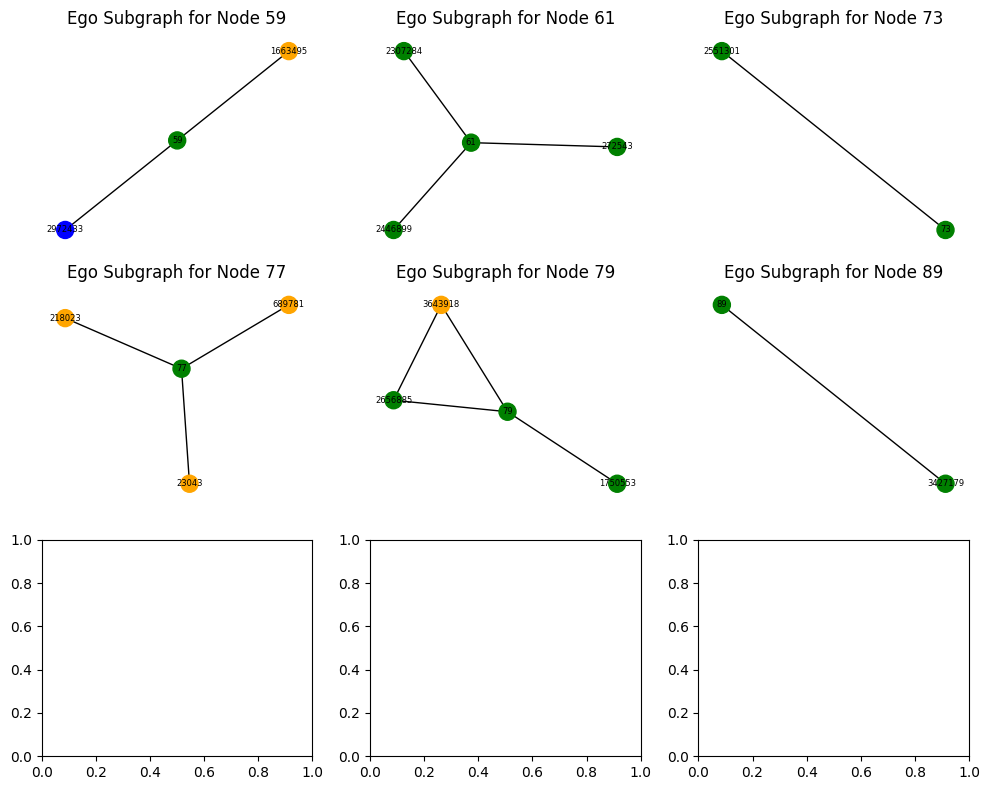

In [174]:
ego_plot(g, normal_l[10:16], radius=1)

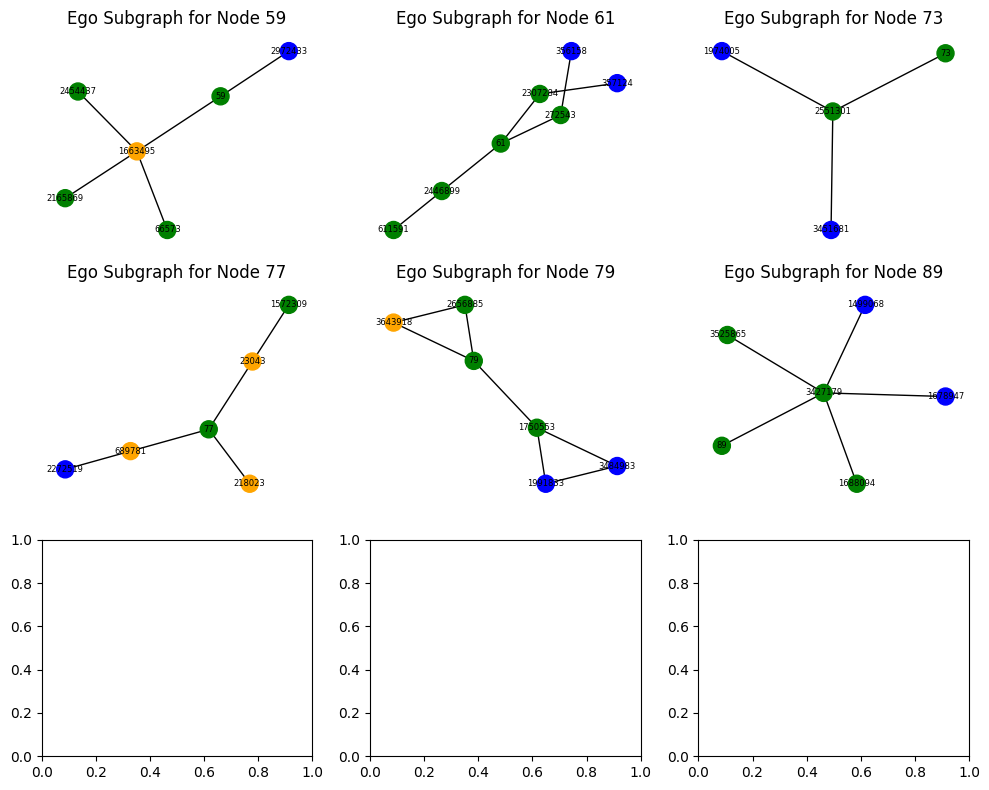

In [175]:
ego_plot(g, normal_l[10:16], radius=2)

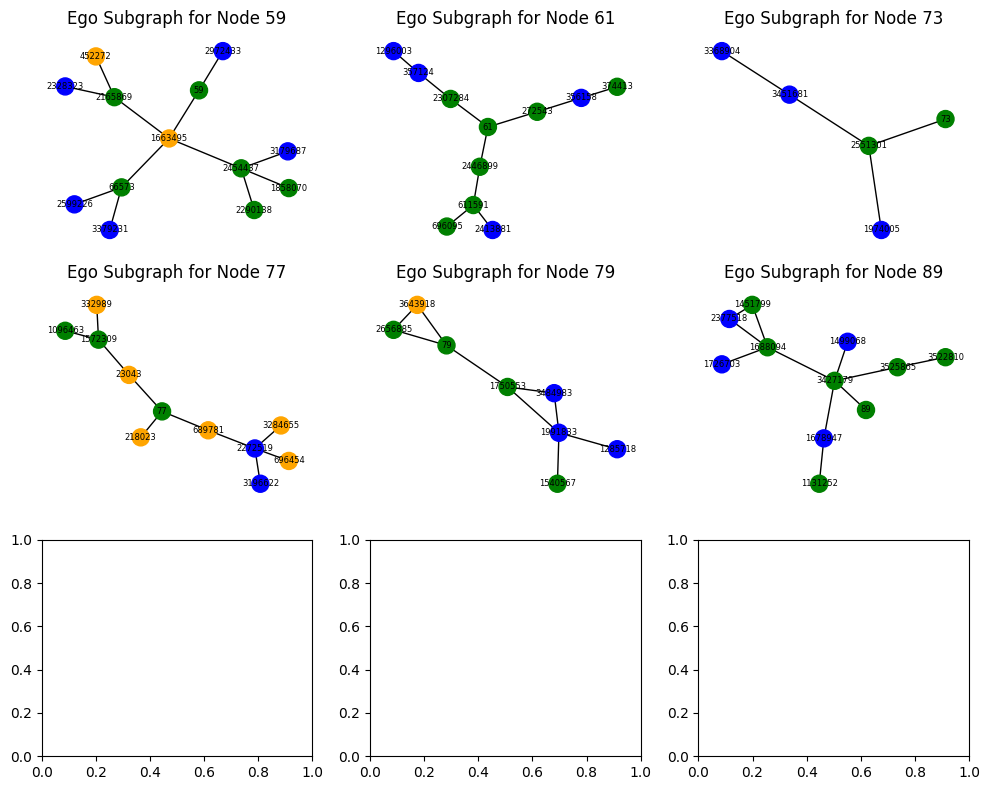

In [176]:
ego_plot(g, normal_l[10:16], radius=3)

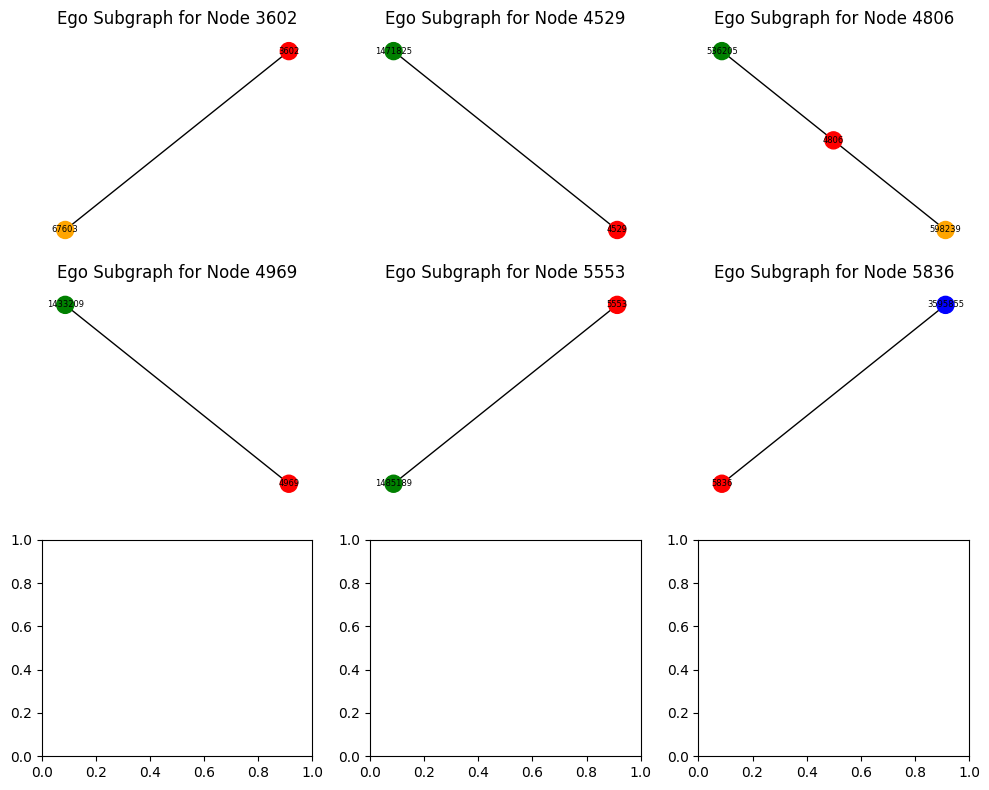

In [177]:
ego_plot(g, fraud_l[10:16], radius=1)

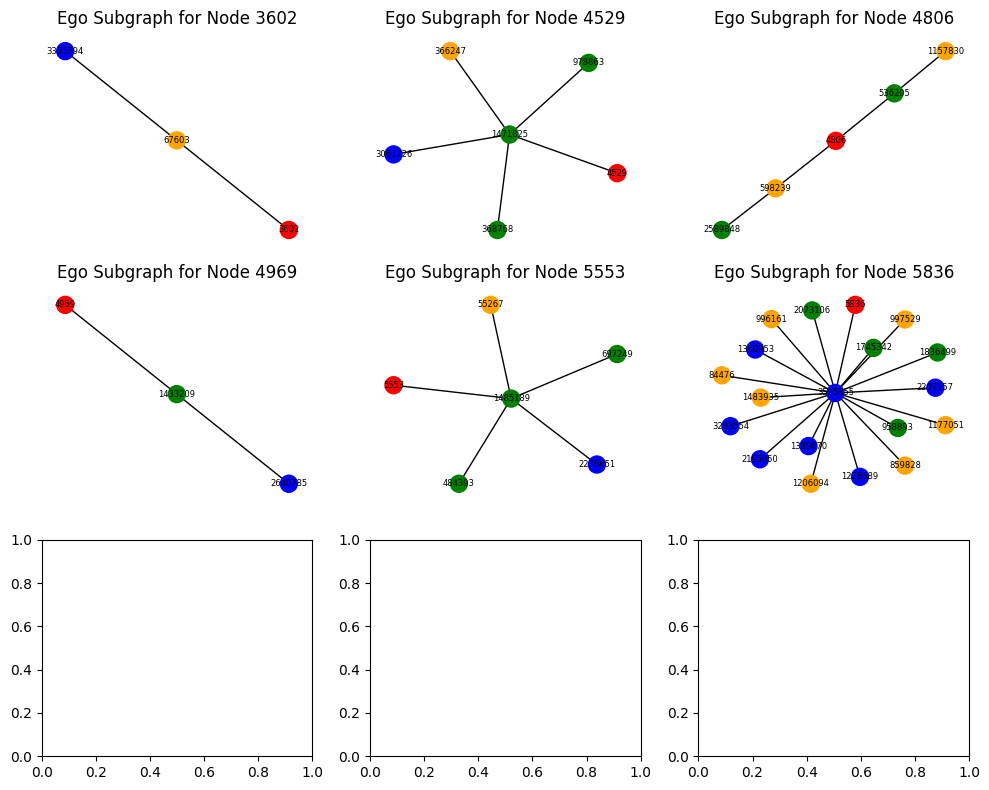

In [178]:
ego_plot(g, fraud_l[10:16], radius=2)

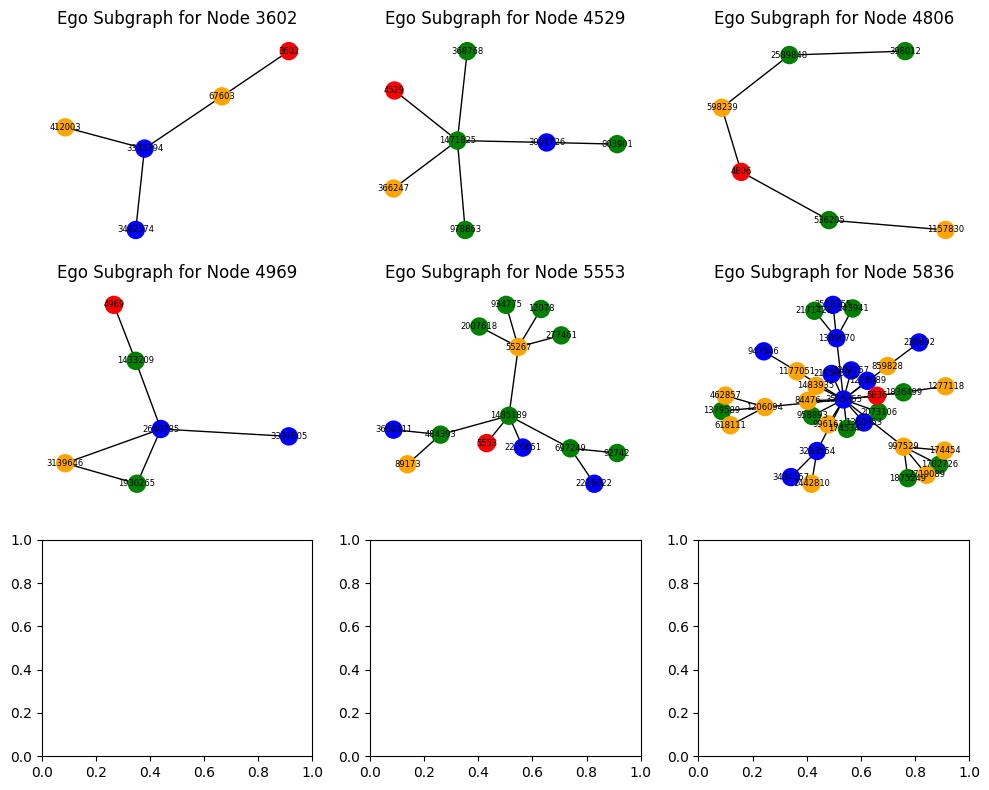

In [180]:
ego_plot(g, fraud_l[10:16], radius=3)